In [1]:
# Step 0 — Imports + Config + Helpers (run first)
from __future__ import annotations

import json
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **kwargs: x  # type: ignore

import warnings
warnings.filterwarnings("ignore")

# -------------------------
# Config (edit here only)
# -------------------------
@dataclass(frozen=True)
class Config:
    # Signals
    signals: Tuple[str, ...] = ("ART_MBP", "CVP", "NEPI_RATE", "PLETH_HR", "PLETH_SPO2")
    required_signals: Tuple[str, ...] = ("ART_MBP", "PLETH_HR", "PLETH_SPO2")  # must-have to keep many cases
    include_optional_signals: bool = True  # set False to speed up (skip CVP/NEPI even if available)

    # Resampling
    fs_hz: float = 1.0
    max_len_sec: int = 4 * 3600  # upper cap; grid will auto-trim to cutoff/preop window
    min_len_sec: int = 10 * 60   # 10 minutes
    min_obs_points_per_channel: int = 60  # observed points per REQUIRED channel

    # Feature time window / cutoff (anti-leakage)
    cutoff_mode: str = "early_intraop"  # one of: "early_intraop", "preop"
    t_cut_sec: int = 60 * 60  # 60 minutes for early_intraop
    preop_window_sec: int = 60 * 60  # only used if cutoff_mode="preop"

    # AKI label windows (seconds)
    baseline_window_sec: int = 30 * 24 * 3600
    postop_window_sec: int = 7 * 24 * 3600

    # CV / splits
    n_splits: int = 5
    random_state: int = 42

    # Performance
    max_cases_to_cache: Optional[int] = None  # set e.g. 500 for a faster demo; None = all
    n_threads: int = 4  # parallelize per-case track loads

    # IO
    api_base: str = "https://api.vitaldb.net"
    artifacts_dir: str = "artifacts/demo_5signals"
    cache_dir: str = "artifacts/demo_5signals/cache_npz"
    tables_dir: str = "artifacts/demo_5signals/tables"
    scalers_dir: str = "artifacts/demo_5signals/scalers"
    plots_dir: str = "artifacts/demo_5signals/plots"

CFG = Config()
print(CFG)

# -------------------------
# Paths
# -------------------------
ARTIFACTS_DIR = Path(CFG.artifacts_dir)
CACHE_DIR = Path(CFG.cache_dir)
TABLES_DIR = Path(CFG.tables_dir)
SCALERS_DIR = Path(CFG.scalers_dir)
PLOTS_DIR = Path(CFG.plots_dir)
for d in [ARTIFACTS_DIR, CACHE_DIR, TABLES_DIR, SCALERS_DIR, PLOTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Save config alongside artifacts for audit/repro
config_path = ARTIFACTS_DIR / "config.json"
config_path.write_text(json.dumps(asdict(CFG), indent=2), encoding="utf-8")
print(f"Saved config: {config_path}")

# -------------------------
# Utility helpers
# -------------------------
def _read_or_fetch_csv(name: str, url: str, *, force: bool = False) -> pd.DataFrame:
    """Reads a cached CSV from TABLES_DIR or fetches it from VitalDB API."""
    path = TABLES_DIR / name
    if path.exists() and not force:
        return pd.read_csv(path)
    df = pd.read_csv(url)
    df.to_csv(path, index=False)
    return df

def _save_json(path: Path, obj) -> None:
    path.write_text(json.dumps(obj, indent=2), encoding="utf-8")

def _safe_lower_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.lower()

def _ensure_cols(df: pd.DataFrame, cols: Iterable[str], df_name: str) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"{df_name} missing columns: {missing}. Available: {list(df.columns)[:50]}")

def _infer_time_value_cols(df: pd.DataFrame) -> Tuple[str, str]:
    """Infer time/value columns from a track dataframe fetched from the API."""
    cols = [c.lower() for c in df.columns]
    time_candidates = ["t", "time", "dt", "sec", "seconds"]
    value_candidates = ["v", "value", "val", "y"]
    t_col = next((df.columns[i] for i, c in enumerate(cols) if c in time_candidates), None)
    v_col = next((df.columns[i] for i, c in enumerate(cols) if c in value_candidates), None)
    if t_col is None or v_col is None:
        # fallback: 1st two columns
        if df.shape[1] >= 2:
            return df.columns[0], df.columns[1]
        raise ValueError(f"Cannot infer time/value cols from columns: {list(df.columns)}")
    return t_col, v_col

def _effective_grid_start_end() -> Tuple[float, float]:
    """Return (start_sec, end_sec) for GRID_T, trimmed to the feature window."""
    if CFG.cutoff_mode == "preop":
        start = -float(CFG.preop_window_sec)
        end = 0.0
        return start, end
    # early_intraop: only need up to t_cut_sec
    start = 0.0
    end = float(min(CFG.max_len_sec, CFG.t_cut_sec))
    return start, end

def _grid_seconds() -> np.ndarray:
    dt = 1.0 / float(CFG.fs_hz)
    start, end = _effective_grid_start_end()
    # end is exclusive in arange; include endpoint-ish by adding dt
    return np.arange(start, end + 1e-6, dt, dtype=np.float32)

GRID_T = _grid_seconds()
print(f"GRID_T: start={GRID_T[0]} sec, end={GRID_T[-1]} sec, T={len(GRID_T)}")

# Ordered regex fallback patterns per signal (edit if needed)
PATTERNS: Dict[str, List[str]] = {
    "ART_MBP": [r"(^|/)ART_MBP$", r"ART_MBP", r"\bMBP\b"],
    "CVP": [r"(^|/)CVP$", r"\bCVP\b"],
    "NEPI_RATE": [r"(^|/)NEPI_RATE$", r"NEPI_RATE", r"NOREPI", r"NOREP"],
    "PLETH_HR": [r"(^|/)PLETH_HR$", r"PLETH_HR", r"\bHR\b"],
    "PLETH_SPO2": [r"(^|/)PLETH_SPO2$", r"PLETH_SPO2", r"\bSPO2\b"],
}

# Per-signal transforms
def transform_signal(name: str, x: np.ndarray) -> np.ndarray:
    """Transform observed signal values in-place (clip/log). Input x is 1D float32."""
    if name == "ART_MBP":
        return np.clip(x, 0.0, 200.0)
    if name == "PLETH_HR":
        return np.clip(x, 0.0, 250.0)
    if name == "PLETH_SPO2":
        return np.clip(x, 0.0, 100.0)
    if name == "CVP":
        return np.clip(x, -5.0, 30.0)
    if name == "NEPI_RATE":
        x = np.maximum(x, 0.0)
        return np.log1p(x)
    return x

print("Ready: imports/config/helpers")

Config(signals=('ART_MBP', 'CVP', 'NEPI_RATE', 'PLETH_HR', 'PLETH_SPO2'), required_signals=('ART_MBP', 'PLETH_HR', 'PLETH_SPO2'), include_optional_signals=True, fs_hz=1.0, max_len_sec=14400, min_len_sec=600, min_obs_points_per_channel=60, cutoff_mode='early_intraop', t_cut_sec=3600, preop_window_sec=3600, baseline_window_sec=2592000, postop_window_sec=604800, n_splits=5, random_state=42, max_cases_to_cache=None, n_threads=4, api_base='https://api.vitaldb.net', artifacts_dir='artifacts/demo_5signals', cache_dir='artifacts/demo_5signals/cache_npz', tables_dir='artifacts/demo_5signals/tables', scalers_dir='artifacts/demo_5signals/scalers', plots_dir='artifacts/demo_5signals/plots')
Saved config: artifacts\demo_5signals\config.json
GRID_T: start=0.0 sec, end=3600.0 sec, T=3601
Ready: imports/config/helpers


### Step 0 — Minimal reproducibility (just enough)
- Fix seed, log package versions.
- Save artifacts (always): `labels.csv`, `manifest_5signals.csv`, `df_usable.csv`, `folds.json`.

### Step 1 — Build AKI label + provenance (**NO leakage**)
- Build **baseline Cr** from `dt ∈ [-30d, 0]` (pick the closest-to-0 measurement).
- Build **postop max Cr** from `dt ∈ [0, +7d]` (take max).
- Define `AKI = 1` if `postop_max_cr >= 1.5 * baseline_cr` else `0`.
- Save label provenance (mandatory for audit/debug):
  - `baseline_cr`, `baseline_dt`, `postop_max_cr`, `postop_dt_of_max` (if derivable),
  - `n_preop_labs`, `n_postop_labs`.
- **Baseline missingness policy (MUST choose & document):**
  - Prefer **exclude** cases without baseline or without postop labs (to keep labels clean).
  - (Optional experiment only) keep them with explicit `label_missing_flag`, but do NOT silently impute.

### Step 1.5 — Define feature time window (anti-label-leakage rule) (**MUST enforce**) 
> Because AKI label is determined from labs in `[0, +7d]`, the modeling goal must be explicit.
- Choose exactly one mode for signal extraction:
  - **Pre-op**: use signals where `t <= 0` only, OR
  - **Early intra-op**: use signals where `t <= t_cut` (e.g., 30–60 min).
- Enforce cutoff per case during ingestion: any sample after cutoff must be treated as missing (`mask=0`, value=0).
- Save `cutoff_mode`, `t_cut`, and `cutoff_time_used` in cached meta.

### Step 2 — Manifest (caseid → tid) for **5 tracks** with strict AND constraint
- Required signals: `ART_MBP`, `CVP`, `NEPI_RATE`, `PLETH_HR`, `PLETH_SPO2`.
- Build `manifest_5signals.csv` using **ordered regex fallback** per signal.
- If multiple tids match a signal:
  - Prefer selecting tid by **observed density within cutoff window** (quick-load, resample, choose max `mask.sum()`),
  - Not only by “longest duration” (can be long-but-empty/noisy).
- Strict AND constraint (for this notebook): keep only cases with **all 5 tids present**.
- Save manifest for audit (include chosen tid per signal; optionally keep candidate list).

### Step 3 — Ingestion → tensor + mask (missingness-aware) + cache
- Load each tid as irregular `(time, value)` series.
- Resample irregular → uniform grid (e.g., 1Hz) **without extrapolation**:
  - Interpolate only within `[t_min, t_max]` of observed samples; outside = `NaN`.
- Build **mask channel** per signal: `mask=1` iff the grid point is truly observed/interpolated from real samples; else `0`.
- Replace `NaN → 0` in signal values *after* building mask (so missing stays identifiable).

**Transforms / outlier handling (distribution-stable):**
- `ART_MBP`: physiologic clip (e.g., `[0, 200]`).
- `PLETH_HR`: clip (e.g., `[0, 250]`).
- `PLETH_SPO2`: clip (e.g., `[0, 100]`).
- `CVP`: require sanity checks + robust clipping:
  - Run quantile/range checks to detect unit mismatch/artifacts,
  - Prefer **train-fold quantile clip** later (avoid hard-coded thresholds when possible).
- `NEPI_RATE`: handle zero-inflation + skew:
  - Transform value: `log1p(max(x, 0))`,
  - Do NOT conflate missing with zero-dose: the **NEPI mask** must remain a first-class input feature.

**Quality gates (MUST):**
- Enforce `min_len_sec` after cutoff (exclude too-short cases).
- Enforce `min_obs_points` **per channel** using `mask.sum()` (exclude near-empty signals).
- Compute `valid_len` from cutoff + observed region (used for masked pooling later).

**Cache (per case):**
- Save `.npz` with:
  - `x` shape `(10, T)` = 5 signals + 5 masks,
  - `valid_len`, and meta: `t_min/t_max`, obs counts per channel, cutoff info.

### Step 4 — Data QA (must-have before modeling)
- Attrition table: `labelled → has_5_tids → pass_cutoff_len → pass_min_obs_each_channel → usable`.
- Missingness report per channel: `%mask==1`, plus NEPI `%nonzero among observed`.
- Sanity distribution checks per channel (quantiles/histograms) to catch unit mismatch/artifacts (esp. CVP/NEPI).
- Plot a few random traces: signal + mask overlays (quick visual verification).

### Step 5 — Split folds (case-level only)
- Perform `k=5` stratified split by `aki` at **case level** (never by window).
- If patient-id exists, use `StratifiedGroupKFold` to avoid patient leakage.
- Save `folds.json` (list of caseids per fold) for reproducibility.

### Step 6 — Per-fold normalization (train-only, mask-aware) (**critical**)
- Fit normalization stats on **train-fold only** using only values where `mask==1`.
- Apply to train/val; keep missing points at `0` with `mask=0`.
- Prefer robust scaling where needed:
  - `NEPI_RATE`: `log1p` then **median/IQR** (often better than mean/std),
  - `CVP`: consider train-fold quantile clip + (mean/std or robust).
- Save per-fold scalers for audit/inference consistency.

## 1) Load VitalDB tables + build AKI labels (with provenance)
This section creates `labels.csv` (case-level AKI labels) from `/labs` using creatinine (`cr`).

In [2]:
# Step 1 — Load /cases, /trks, /labs (cached) + build labels
cases_url = f"{CFG.api_base}/cases"
trks_url = f"{CFG.api_base}/trks"
labs_url = f"{CFG.api_base}/labs"

df_cases = _read_or_fetch_csv("cases.csv", cases_url)
df_trks = _read_or_fetch_csv("trks.csv", trks_url)
df_labs = _read_or_fetch_csv("labs.csv", labs_url)

print("cases:", df_cases.shape, "columns:", list(df_cases.columns)[:12])
print("trks :", df_trks.shape, "columns:", list(df_trks.columns)[:12])
print("labs :", df_labs.shape, "columns:", list(df_labs.columns)[:12])

# --- Label builder (AKI from Cr) ---
def build_aki_labels_from_labs(
    labs: pd.DataFrame,
    *,
    baseline_window_sec: int,
    postop_window_sec: int,
    name_col: str = "name",
    dt_col: str = "dt",
    result_col: str = "result",
    caseid_col: str = "caseid",
    cr_names: Tuple[str, ...] = ("cr", "creatinine"),
) -> pd.DataFrame:
    labs = labs.copy()
    _ensure_cols(labs, [caseid_col, name_col, dt_col, result_col], "labs")
    labs[name_col] = _safe_lower_series(labs[name_col])
    labs = labs[labs[name_col].isin(cr_names)].copy()
    labs[dt_col] = pd.to_numeric(labs[dt_col], errors="coerce")
    labs[result_col] = pd.to_numeric(labs[result_col], errors="coerce")
    labs = labs.dropna(subset=[caseid_col, dt_col, result_col])
    labs[caseid_col] = pd.to_numeric(labs[caseid_col], errors="coerce").astype("Int64")
    labs = labs.dropna(subset=[caseid_col])
    labs[caseid_col] = labs[caseid_col].astype(int)

    # Baseline window: [-baseline_window_sec, 0]
    pre = labs[(labs[dt_col] <= 0) & (labs[dt_col] >= -baseline_window_sec)].copy()
    pre = pre.sort_values([caseid_col, dt_col])
    # Closest-to-0 is max dt within window
    idx_base = pre.groupby(caseid_col)[dt_col].idxmax()
    baseline = pre.loc[idx_base, [caseid_col, dt_col, result_col]].rename(
        columns={dt_col: "baseline_dt", result_col: "baseline_cr"}
    )

    # Postop window: [0, postop_window_sec]
    post = labs[(labs[dt_col] >= 0) & (labs[dt_col] <= postop_window_sec)].copy()
    post = post.sort_values([caseid_col, result_col, dt_col])
    # Max Cr; for ties pick latest dt
    idx_post = post.groupby(caseid_col)[result_col].idxmax()
    postop = post.loc[idx_post, [caseid_col, dt_col, result_col]].rename(
        columns={dt_col: "postop_dt_of_max", result_col: "postop_max_cr"}
    )

    # Counts for provenance
    n_pre = pre.groupby(caseid_col).size().rename("n_preop_labs")
    n_post = post.groupby(caseid_col).size().rename("n_postop_labs")

    out = baseline.merge(postop, on=caseid_col, how="inner")
    out = out.merge(n_pre, on=caseid_col, how="left").merge(n_post, on=caseid_col, how="left")
    out["aki"] = (out["postop_max_cr"] >= 1.5 * out["baseline_cr"]).astype(int)
    out = out.sort_values(caseid_col).reset_index(drop=True)
    return out

df_labels = build_aki_labels_from_labs(
    df_labs,
    baseline_window_sec=CFG.baseline_window_sec,
    postop_window_sec=CFG.postop_window_sec,
)

labels_path = ARTIFACTS_DIR / "labels.csv"
df_labels.to_csv(labels_path, index=False)
print(f"Saved labels: {labels_path}")
print("Labelled cases:", len(df_labels), " AKI positive:", int(df_labels['aki'].sum()))
df_labels.head()

cases: (6388, 74) columns: ['caseid', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend', 'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp']
trks : (486449, 3) columns: ['caseid', 'tname', 'tid']
labs : (928448, 4) columns: ['caseid', 'dt', 'name', 'result']
Saved labels: artifacts\demo_5signals\labels.csv
Labelled cases: 3242  AKI positive: 127


,caseid,baseline_dt,baseline_cr,postop_dt_of_max,postop_max_cr,n_preop_labs,n_postop_labs,aki
0,5,-2968,1.83,131894,4.43,1,18,1
1,7,-97335,0.84,16337,0.82,1,4,0
2,12,-91787,0.58,166708,0.65,1,16,0
3,13,-55795,0.86,89931,0.78,1,2,0
4,16,-81225,0.91,150205,1.02,1,5,0


## 2) Build manifest (caseid → tid) for 5 tracks
This section creates `manifest_5signals.csv` by mapping `tname` → `tid` using ordered regex fallback.

In [3]:
# Step 2 — Build manifest_5signals.csv (relaxed: keep many cases)
_ensure_cols(df_trks, ["caseid", "tid", "tname"], "trks")
df_trks = df_trks.copy()
df_trks["caseid"] = pd.to_numeric(df_trks["caseid"], errors="coerce").astype("Int64")
df_trks = df_trks.dropna(subset=["caseid"]).copy()
df_trks["caseid"] = df_trks["caseid"].astype(int)
df_trks["tid"] = df_trks["tid"].astype(str)
df_trks = df_trks[df_trks["tid"].str.len() > 0].copy()
df_trks["tname"] = df_trks["tname"].astype(str)

# Guardrails: the manifest will be empty if there are no labelled cases
if "df_labels" not in globals() or df_labels is None or len(df_labels) == 0:
    raise ValueError(
        "df_labels is empty, so there are no labelled caseids to build a manifest from. "
        "This usually means the AKI label builder found no usable baseline/postop creatinine labs. "
        "Check Step 1 outputs (how many Cr labs were found, and that labs['name'] contains 'cr'/'creatinine')."
    )

label_caseids = set(df_labels["caseid"].astype(int).tolist())
trks_lab = df_trks[df_trks["caseid"].isin(label_caseids)].copy()
print("Tracks restricted to labelled cases:", trks_lab.shape)
if len(trks_lab) == 0:
    print("No tracks matched labelled caseids.")
    print("n_labelled_caseids:", len(label_caseids), "  n_total_tracks:", len(df_trks))
    raise ValueError(
        "No tracks available after restricting to labelled cases. "
        "Either df_labels caseids do not exist in df_trks, or df_labels is built from a different dataset/time."
    )

import re
def pick_tid_for_signal(group: pd.DataFrame, signal: str) -> Optional[str]:
    """Pick a single tid for a signal using ordered regex fallback on tname."""
    pats = PATTERNS.get(signal, [signal])
    tname = group["tname"].astype(str)
    for pat in pats:
        m = tname.str.contains(pat, regex=True, na=False)
        if m.any():
            return str(group.loc[m, "tid"].iloc[0])
    return None

# Build manifest row-by-row (case-level)
manifest_rows = []
for caseid, g in tqdm(trks_lab.groupby("caseid"), desc="Building manifest", unit="case"):
    row = {"caseid": int(caseid)}
    for sig in CFG.signals:
        row[f"tid_{sig}"] = pick_tid_for_signal(g, sig)
    manifest_rows.append(row)

tid_cols = [f"tid_{s}" for s in CFG.signals]
expected_cols = ["caseid", *tid_cols]
df_manifest = pd.DataFrame(manifest_rows, columns=expected_cols)

# Relaxed cohort: keep cases that have ALL required_signals; allow missing optional signals
required_tid_cols = [f"tid_{s}" for s in CFG.required_signals]
df_manifest_relaxed = df_manifest.dropna(subset=required_tid_cols).copy()
df_manifest_relaxed = df_manifest_relaxed.sort_values("caseid").reset_index(drop=True)

manifest_path = ARTIFACTS_DIR / "manifest_relaxed.csv"
df_manifest_relaxed.to_csv(manifest_path, index=False)
print(f"Saved manifest: {manifest_path}")
print("Cases with required signals:", len(df_manifest_relaxed), " / labelled:", len(df_labels))

# Keep df_manifest_all name for downstream cells
df_manifest_all = df_manifest_relaxed
df_manifest_all.head()

Tracks restricted to labelled cases: (258130, 3)


Building manifest:   0%|          | 0/3242 [00:00<?, ?case/s]

Saved manifest: artifacts\demo_5signals\manifest_relaxed.csv
Cases with required signals: 2504  / labelled: 3242


,caseid,tid_ART_MBP,tid_CVP,tid_NEPI_RATE,tid_PLETH_HR,tid_PLETH_SPO2
0,7,30a4c59beb2c29881c969ff720e489aba3465c30,20c3c458496ea1fc637f3d94122e33167ef5218e,None,f3cce12094dc3734fbee47ba2180c990ca51e348,a81bc2962fc0ac48297eb856ff3710dda5c3a276
1,12,68c782020e500fc51e9b47352805e9ffdc088de4,5f67c82cf764ac4972b0154d992ddfae5319d696,None,6b479f97477ba56ddcc72a86ac5978f274694b9a,dff0c94054cae91ab7849559851b5c0b663e6022
2,13,1f13c262719341c545ec38de4098a5b0b9e51144,None,None,35ad379e06247069984ecb20ec025dee703b922d,e4ae3d53facdbefea02bbf8b757e16f69dd06bc9
3,16,0254d97febeb440b551252ac4c5d2ef2740d4172,None,None,814376860936ea95a151626820bd7f0adbc0e2b2,0780cae61d8e7a775654c3b94f35df25cb5a3df7
4,17,c2f593e2322e78d975ad049c1671537f2974fda7,1ed0dd3eaf16bcbb4f3930bf576b076fc7ff5b60,a5b6a3a6d146104c5a912f96d306b37a055f593f,880b8774d9297abf030b2df878814f413d75451f,f0d3fa0a4dde9d7506127ddb497af383e83c5c12


## 3) Ingest 5 tracks → resample → (5 signals + 5 masks) tensor → cache npz
This section writes per-case `.npz` tensors and produces `df_usable.csv` with quality gates enforced.

In [4]:
# Step 3 — Ingestion helpers + cache writer
from concurrent.futures import ThreadPoolExecutor, as_completed
import io
import os
import time
import threading

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# -------------------------
# Robust HTTP (timeout + retry)
_thread_local = threading.local()

def _get_session() -> requests.Session:
    s = getattr(_thread_local, "session", None)
    if s is None:
        s = requests.Session()
        retry = Retry(
            total=5,
            connect=5,
            read=5,
            backoff_factor=0.8,
            status_forcelist=(429, 500, 502, 503, 504),
            allowed_methods=("GET",),
            raise_on_status=False,
            respect_retry_after_header=True,
        )
        adapter = HTTPAdapter(max_retries=retry, pool_connections=16, pool_maxsize=16)
        s.mount("http://", adapter)
        s.mount("https://", adapter)
        _thread_local.session = s
    return s

def fetch_track_df(tid: str) -> pd.DataFrame:
    """Fetch a track by tid from VitalDB API with timeouts + retries."""
    url = f"{CFG.api_base}/{str(tid)}"
    sess = _get_session()
    # Use explicit timeouts to prevent hanging forever
    r = sess.get(url, timeout=(5, 30))
    # If still rate-limited after retries, sleep briefly and try once more
    if r.status_code == 429:
        retry_after = r.headers.get("Retry-After")
        try:
            wait = float(retry_after) if retry_after is not None else 5.0
        except Exception:
            wait = 5.0
        time.sleep(min(max(wait, 1.0), 30.0))
        r = sess.get(url, timeout=(5, 30))
    if r.status_code != 200:
        raise RuntimeError(f"HTTP {r.status_code} fetching tid={tid}")
    # Pandas can read from in-memory text buffer
    return pd.read_csv(io.StringIO(r.text))

def load_track_df_cached(tid: str, *, force: bool = False) -> pd.DataFrame:
    """Fetch track CSV once and cache under TABLES_DIR/tracks/{tid}.csv (atomic write)."""
    track_dir = TABLES_DIR / "tracks"
    track_dir.mkdir(parents=True, exist_ok=True)
    safe_tid = str(tid)
    path = track_dir / f"{safe_tid}.csv"
    if path.exists() and not force:
        try:
            # Guard against truncated/empty cache files (can happen if a previous run was interrupted)
            if path.stat().st_size < 64:
                raise ValueError("cache file too small")
            return pd.read_csv(path)
        except Exception:
            # fall through to refetch
            pass
    df = fetch_track_df(safe_tid)
    tmp_path = track_dir / f"{safe_tid}.csv.tmp"
    df.to_csv(tmp_path, index=False)
    os.replace(str(tmp_path), str(path))
    return df

def resample_to_grid(
    times: np.ndarray,
    values: np.ndarray,
    grid_t: np.ndarray,
    *,
    cutoff_sec: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Resample irregular (times, values) onto grid_t using interpolation, without extrapolation.
    Returns (signal, mask) where mask==1 indicates interpolated/observed inside data support and before cutoff.
    """
    times = np.asarray(times, dtype=np.float64)
    values = np.asarray(values, dtype=np.float64)
    ok = np.isfinite(times) & np.isfinite(values)
    times = times[ok]
    values = values[ok]
    if times.size == 0:
        sig = np.zeros_like(grid_t, dtype=np.float32)
        mask = np.zeros_like(grid_t, dtype=np.float32)
        return sig, mask

    order = np.argsort(times)
    times = times[order]
    values = values[order]

    # Remove duplicate times (keep last)
    times_rev = times[::-1]
    values_rev = values[::-1]
    _, uniq_idx_rev = np.unique(times_rev, return_index=True)
    keep_rev = np.sort(uniq_idx_rev)
    times = times_rev[keep_rev][::-1]
    values = values_rev[keep_rev][::-1]

    t_min = float(np.min(times))
    t_max = float(np.max(times))

    inside = (grid_t >= t_min) & (grid_t <= t_max) & (grid_t <= cutoff_sec)
    sig = np.full_like(grid_t, np.nan, dtype=np.float32)
    mask = np.zeros_like(grid_t, dtype=np.float32)
    if inside.any():
        sig[inside] = np.interp(grid_t[inside].astype(np.float64), times, values).astype(np.float32)
        mask[inside] = 1.0
    sig = np.nan_to_num(sig, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32)
    return sig, mask

def get_cutoff_sec() -> float:
    if CFG.cutoff_mode == "preop":
        return 0.0
    return float(min(CFG.t_cut_sec, CFG.max_len_sec))

CUTOFF_SEC = get_cutoff_sec()
print("Cutoff mode:", CFG.cutoff_mode, "cutoff_sec:", CUTOFF_SEC)

def _tid_or_none(v) -> Optional[str]:
    if v is None:
        return None
    if isinstance(v, float) and np.isnan(v):
        return None
    s = str(v).strip()
    if s == "" or s.lower() in ("nan", "none", "null"):
        return None
    return s

def _process_one_signal(sig_name: str, tid: str) -> Tuple[str, np.ndarray, np.ndarray, int]:
    df_track = load_track_df_cached(tid)
    t_col, v_col = _infer_time_value_cols(df_track)
    t = pd.to_numeric(df_track[t_col], errors="coerce").to_numpy(dtype=np.float64)
    v = pd.to_numeric(df_track[v_col], errors="coerce").to_numpy(dtype=np.float64)
    sig, mask = resample_to_grid(t, v, GRID_T, cutoff_sec=CUTOFF_SEC)
    sig = transform_signal(sig_name, sig.astype(np.float32))
    sig = sig * mask
    return sig_name, sig.astype(np.float32), mask.astype(np.float32), int(mask.sum())

def build_case_tensor_from_manifest_row(row: pd.Series, *, executor: ThreadPoolExecutor) -> Tuple[np.ndarray, int, Dict[str, int]]:
    """
    Returns x (10,T), valid_len, obs_counts per signal index.
    Missing optional signals are allowed: their (signal,mask) will be all zeros.
    """
    T = len(GRID_T)
    sig_names = list(CFG.signals)
    n_sig = len(sig_names)
    sig_mat = np.zeros((n_sig, T), dtype=np.float32)
    mask_mat = np.zeros((n_sig, T), dtype=np.float32)
    obs_counts: Dict[str, int] = {name: 0 for name in sig_names}

    futures = {}
    for name in sig_names:
        is_required = name in CFG.required_signals
        is_optional = not is_required
        if is_optional and not CFG.include_optional_signals:
            continue
        tid = _tid_or_none(row.get(f"tid_{name}"))
        if tid is None:
            continue
        futures[executor.submit(_process_one_signal, name, tid)] = name

    for fut in as_completed(futures):
        name = futures[fut]
        try:
            sig_name, sig, mask, n_obs = fut.result()
        except Exception:
            # Treat a failed download/parse as missing for this signal (do NOT kill the whole run)
            obs_counts[name] = 0
            continue
        i = sig_names.index(sig_name)
        sig_mat[i] = sig
        mask_mat[i] = mask
        obs_counts[sig_name] = int(n_obs)

    any_mask = (mask_mat.sum(axis=0) > 0)
    valid_len = int(np.max(np.where(any_mask)[0]) + 1) if any_mask.any() else 0
    x = np.concatenate([sig_mat, mask_mat], axis=0).astype(np.float32)
    return x, valid_len, obs_counts

def quality_gates(obs_counts: Dict[str, int], valid_len: int) -> Tuple[bool, str]:
    for sig_name in CFG.required_signals:
        if obs_counts.get(sig_name, 0) < CFG.min_obs_points_per_channel:
            return False, f"min_obs_fail_required:{sig_name}"
    if valid_len < int(CFG.min_len_sec * CFG.fs_hz):
        return False, "min_len_fail"
    return True, "ok"

# Build cache for all manifest cases (optionally limit for faster runs)
df_manifest_run = df_manifest_all
if CFG.max_cases_to_cache is not None:
    df_manifest_run = df_manifest_run.head(int(CFG.max_cases_to_cache)).copy()
print("Caching cases:", len(df_manifest_run), "(of", len(df_manifest_all), ")")

usable_rows = []
failed_rows = []

with ThreadPoolExecutor(max_workers=int(CFG.n_threads)) as ex:
    for _, row in tqdm(df_manifest_run.iterrows(), total=len(df_manifest_run), desc="Caching cases", unit="case"):
        caseid = int(row["caseid"])
        out_path = CACHE_DIR / f"case_{caseid}.npz"
        if out_path.exists():
            usable_rows.append({"caseid": caseid, "cache_path": str(out_path), "status": "cached"})
            continue
        try:
            x, valid_len, obs_counts = build_case_tensor_from_manifest_row(row, executor=ex)
            ok, reason = quality_gates(obs_counts, valid_len)
            if not ok:
                failed_rows.append({"caseid": caseid, "reason": reason, **{f"obs_{k}": v for k, v in obs_counts.items()}, "valid_len": valid_len})
                continue
            np.savez_compressed(
                out_path,
                x=x,
                valid_len=np.int32(valid_len),
                grid_t=GRID_T,
                cutoff_mode=np.array([CFG.cutoff_mode]),
                cutoff_sec=np.float32(CUTOFF_SEC),
                obs_counts=np.array([obs_counts], dtype=object),
            )
            usable_rows.append({"caseid": caseid, "cache_path": str(out_path), "status": "new", **{f"obs_{k}": v for k, v in obs_counts.items()}, "valid_len": valid_len})
        except Exception as e:
            failed_rows.append({"caseid": caseid, "reason": f"exception:{type(e).__name__}", "detail": str(e)[:200]})

df_usable = pd.DataFrame(usable_rows)
df_failed = pd.DataFrame(failed_rows)
usable_path = ARTIFACTS_DIR / "df_usable.csv"
failed_path = ARTIFACTS_DIR / "df_failed.csv"
df_usable.to_csv(usable_path, index=False)
df_failed.to_csv(failed_path, index=False)
print(f"Saved usable: {usable_path} ({len(df_usable)} cases)")
print(f"Saved failed: {failed_path} ({len(df_failed)} cases)")
df_usable.head()

Cutoff mode: early_intraop cutoff_sec: 3600.0
Caching cases: 2504 (of 2504 )


Caching cases:   0%|          | 0/2504 [00:00<?, ?case/s]

Saved usable: artifacts\demo_5signals\df_usable.csv (2413 cases)
Saved failed: artifacts\demo_5signals\df_failed.csv (91 cases)


,caseid,cache_path,status
0,7,artifacts\demo_5signals\cache_npz\case_7.npz,cached
1,12,artifacts\demo_5signals\cache_npz\case_12.npz,cached
2,13,artifacts\demo_5signals\cache_npz\case_13.npz,cached
3,16,artifacts\demo_5signals\cache_npz\case_16.npz,cached
4,17,artifacts\demo_5signals\cache_npz\case_17.npz,cached


## 4) Data QA (attrition + missingness + sanity quantiles)
Run this after caching to verify distribution and detect unit/artifact issues (especially CVP/NEPI).

In [5]:
# Step 4 — QA summaries
print("--- Attrition ---")
n_labelled = len(df_labels)
n_manifest = len(df_manifest_all)
n_usable = len(df_usable)
print({"labelled": n_labelled, "has_5_tids": n_manifest, "usable_cached": n_usable})

print("\n--- Label distribution (usable only) ---")
usable_caseids = set(pd.to_numeric(df_usable["caseid"], errors="coerce").dropna().astype(int).tolist())
df_labels_usable = df_labels[df_labels["caseid"].isin(usable_caseids)].copy()
print(df_labels_usable["aki"].value_counts(dropna=False))

print("\n--- Missingness report from cache metadata ---")
# Use df_usable obs_* columns if present
obs_cols = [c for c in df_usable.columns if c.startswith("obs_")]
if obs_cols:
    desc = df_usable[obs_cols + (["valid_len"] if "valid_len" in df_usable.columns else [])].describe().T
    display(desc)
else:
    print("No obs_* columns found in df_usable (maybe all were already cached).")

print("\n--- Sample quantiles by channel (observed values only; from a small sample) ---")
sample_n = min(50, len(df_usable))
sample_caseids = df_usable["caseid"].astype(int).head(sample_n).tolist()
sig_names = list(CFG.signals)
quant_rows = []
for cid in tqdm(sample_caseids, desc="Quantiles", unit="case"):
    path = CACHE_DIR / f"case_{cid}.npz"
    if not path.exists():
        continue
    data = np.load(path, allow_pickle=True)
    x = data["x"].astype(np.float32)
    n_sig = len(sig_names)
    sig = x[:n_sig]
    mask = x[n_sig:]
    for i, name in enumerate(sig_names):
        vals = sig[i][mask[i] > 0.5]
        if vals.size == 0:
            continue
        q = np.quantile(vals, [0.01, 0.5, 0.99]).astype(float)
        quant_rows.append({"caseid": cid, "signal": name, "q01": q[0], "q50": q[1], "q99": q[2], "n_obs": int(vals.size)})

df_quant = pd.DataFrame(quant_rows)
if len(df_quant):
    display(df_quant.groupby("signal")[["q01", "q50", "q99", "n_obs"]].median())
else:
    print("No quantiles computed.")

--- Attrition ---
{'labelled': 3242, 'has_5_tids': 2504, 'usable_cached': 2413}

--- Label distribution (usable only) ---
aki
0    2312
1     101
Name: count, dtype: int64

--- Missingness report from cache metadata ---
No obs_* columns found in df_usable (maybe all were already cached).

--- Sample quantiles by channel (observed values only; from a small sample) ---


Quantiles:   0%|          | 0/50 [00:00<?, ?case/s]

,q01,q50,q99,n_obs
signal,,,,
ART_MBP,0.0000,73.23,138.450248,3596.5
CVP,1.0000,4.00,8.000000,991.0
PLETH_HR,56.5000,67.00,100.000000,3597.0
PLETH_SPO2,96.9752,100.00,100.000000,3597.0


## 5) Create StratifiedKFold splits (case-level)
This section produces `folds.json` using `caseid` and `aki` (never split by window).

In [6]:
# Step 5 — StratifiedKFold splits at case level
from sklearn.model_selection import StratifiedKFold

df_master = df_labels_usable.merge(df_manifest_all, on="caseid", how="inner")
df_master = df_master.merge(df_usable[["caseid", "cache_path"]], on="caseid", how="inner")
df_master = df_master.sort_values("caseid").reset_index(drop=True)
master_path = ARTIFACTS_DIR / "cohort_master.csv"
df_master.to_csv(master_path, index=False)
print(f"Saved cohort_master: {master_path} ({len(df_master)} cases)")

caseids = df_master["caseid"].astype(int).to_numpy()
y = df_master["aki"].astype(int).to_numpy()

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.random_state)
folds = []
for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(caseids, y), start=1):
    folds.append({
        "fold": fold_idx,
        "train_caseids": caseids[tr_idx].tolist(),
        "val_caseids": caseids[va_idx].tolist(),
        "n_train": int(len(tr_idx)),
        "n_val": int(len(va_idx)),
        "train_pos": int(y[tr_idx].sum()),
        "val_pos": int(y[va_idx].sum()),
    })

folds_path = ARTIFACTS_DIR / "folds.json"
_save_json(folds_path, folds)
print(f"Saved folds: {folds_path}")
print(pd.DataFrame(folds)[["fold","n_train","n_val","train_pos","val_pos"]])

Saved cohort_master: artifacts\demo_5signals\cohort_master.csv (2413 cases)
Saved folds: artifacts\demo_5signals\folds.json
   fold  n_train  n_val  train_pos  val_pos
0     1     1930    483         81       20
1     2     1930    483         81       20
2     3     1930    483         80       21
3     4     1931    482         81       20
4     5     1931    482         81       20


In [7]:
df_master['aki'].value_counts()

aki
0    2312
1     101
Name: count, dtype: int64

## 6) Per-fold normalization stats (mask-aware; train-only)
This section computes and saves per-fold scalers without applying them globally (to avoid leakage).

In [8]:
# Step 6 — Fit per-fold scalers using only observed values (mask==1) from train cases
def fit_channel_stats(values: np.ndarray, *, robust: bool) -> Dict[str, float]:
    values = values[np.isfinite(values)]
    if values.size == 0:
        return {"type": "empty"}
    if robust:
        med = float(np.median(values))
        q25 = float(np.percentile(values, 25))
        q75 = float(np.percentile(values, 75))
        iqr = float(q75 - q25)
        if iqr <= 1e-6:
            iqr = 1.0
        return {"type": "robust", "median": med, "iqr": iqr, "q25": q25, "q75": q75}
    mean = float(values.mean())
    std = float(values.std())
    if std <= 1e-6:
        std = 1.0
    return {"type": "z", "mean": mean, "std": std}

def load_case_x(caseid: int) -> Tuple[np.ndarray, np.ndarray, int]:
    path = CACHE_DIR / f"case_{int(caseid)}.npz"
    data = np.load(path, allow_pickle=True)
    x = data["x"].astype(np.float32)
    valid_len = int(data["valid_len"])
    n_sig = len(CFG.signals)
    sig = x[:n_sig, :valid_len]
    mask = x[n_sig:, :valid_len]
    return sig, mask, valid_len

def fit_fold_scaler(train_caseids: List[int]) -> Dict[str, Dict[str, float]]:
    sig_names = list(CFG.signals)
    n_sig = len(sig_names)
    # Collect values per channel from train cases (observed only)
    collected: List[List[np.ndarray]] = [[] for _ in range(n_sig)]
    for cid in tqdm(train_caseids, desc="Collect train vals", unit="case"):
        sig, mask, _ = load_case_x(cid)
        for i in range(n_sig):
            vals = sig[i][mask[i] > 0.5]
            if vals.size:
                collected[i].append(vals.astype(np.float32))
    scalers: Dict[str, Dict[str, float]] = {}
    for i, name in enumerate(sig_names):
        vals = np.concatenate(collected[i], axis=0) if collected[i] else np.array([], dtype=np.float32)
        # Robust for NEPI (and optionally CVP); z-score for others
        robust = name in ("NEPI_RATE",)
        scalers[name] = fit_channel_stats(vals, robust=robust)
        # Also store basic quantiles for sanity (not necessarily applied)
        if vals.size:
            scalers[name].update({
                "q001": float(np.quantile(vals, 0.001)),
                "q999": float(np.quantile(vals, 0.999)),
                "n": int(vals.size),
            })
        else:
            scalers[name].update({"q001": None, "q999": None, "n": 0})
    return scalers

def apply_scaler_to_signal(name: str, sig: np.ndarray, mask: np.ndarray, scaler: Dict[str, float]) -> np.ndarray:
    out = sig.copy()
    idx = mask > 0.5
    if not idx.any():
        return out
    if scaler.get("type") == "robust":
        med = float(scaler["median"])
        iqr = float(scaler["iqr"])
        out[idx] = (out[idx] - med) / iqr
        return out
    if scaler.get("type") == "z":
        mean = float(scaler["mean"])
        std = float(scaler["std"])
        out[idx] = (out[idx] - mean) / std
        return out
    return out

# Fit and save scalers per fold
fold_scalers = []
for f in folds:
    fold_idx = int(f["fold"])
    train_caseids = [int(x) for x in f["train_caseids"]]
    scalers = fit_fold_scaler(train_caseids)
    out_path = SCALERS_DIR / f"scalers_fold{fold_idx}.json"
    _save_json(out_path, scalers)
    fold_scalers.append({"fold": fold_idx, "path": str(out_path)})
    print(f"Saved scalers: {out_path}")

fold_scalers_path = ARTIFACTS_DIR / "fold_scalers_index.json"
_save_json(fold_scalers_path, fold_scalers)
print(f"Saved fold scalers index: {fold_scalers_path}")

# Optional helper: load normalized tensor for a fold (for downstream DL model)
def load_case_tensor_for_fold(caseid: int, fold_idx: int) -> Tuple[np.ndarray, int]:
    scalers_path = SCALERS_DIR / f"scalers_fold{int(fold_idx)}.json"
    scalers = json.loads(scalers_path.read_text(encoding="utf-8"))
    sig, mask, valid_len = load_case_x(caseid)
    sig_names = list(CFG.signals)
    for i, name in enumerate(sig_names):
        sig[i] = apply_scaler_to_signal(name, sig[i], mask[i], scalers[name]).astype(np.float32)
    x = np.concatenate([sig, mask], axis=0).astype(np.float32)
    return x, valid_len

print("Ready: per-fold scalers computed. Use load_case_tensor_for_fold(caseid, fold_idx) for DL input.")

Collect train vals:   0%|          | 0/1930 [00:00<?, ?case/s]

Saved scalers: artifacts\demo_5signals\scalers\scalers_fold1.json


Collect train vals:   0%|          | 0/1930 [00:00<?, ?case/s]

Saved scalers: artifacts\demo_5signals\scalers\scalers_fold2.json


Collect train vals:   0%|          | 0/1930 [00:00<?, ?case/s]

Saved scalers: artifacts\demo_5signals\scalers\scalers_fold3.json


Collect train vals:   0%|          | 0/1931 [00:00<?, ?case/s]

Saved scalers: artifacts\demo_5signals\scalers\scalers_fold4.json


Collect train vals:   0%|          | 0/1931 [00:00<?, ?case/s]

Saved scalers: artifacts\demo_5signals\scalers\scalers_fold5.json
Saved fold scalers index: artifacts\demo_5signals\fold_scalers_index.json
Ready: per-fold scalers computed. Use load_case_tensor_for_fold(caseid, fold_idx) for DL input.


## 7) Train 4 models (TCN / GRU / LSTM / BiLSTM) với 5-fold CV + lưu checkpoint
Mục tiêu:
- Mỗi model: ROC-AUC và PR-AUC cho từng fold (1→5)
- Tự động lưu checkpoint theo fold để lần chạy sau **load và bỏ qua train**
- Lưu metrics ra `artifacts/demo_5signals/results/*_5fold_metrics.csv`

In [9]:
# 7A) Model config + training utils (phải chạy trước 7B/7C/7D)

from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import Callable, Dict, List, Tuple

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score, average_precision_score

try:
    from IPython.display import display
except Exception:
    display = print  # fallback

# -------------------------
# Settings (edit if needed)
# -------------------------
FORCE_TRAIN = False  # True: retrain dù đã có checkpoint
EPOCHS = 20
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 1e-4
PATIENCE = 5
MONITOR = "pr_auc"  # "pr_auc" hoặc "roc_auc"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

RESULTS_DIR = ARTIFACTS_DIR / "results"
MODELS_DIR = ARTIFACTS_DIR / "models"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

SIGNAL_NAMES = list(CFG.signals)
N_SIG = len(SIGNAL_NAMES)
INPUT_DIM = N_SIG * 2  # signals + masks

print("DEVICE:", DEVICE)
print("INPUT_DIM:", INPUT_DIM, "(signals+masks)")

# -------------------------
# Load folds + labels from disk
# -------------------------

def _load_folds_from_disk() -> List[Dict]:
    p = ARTIFACTS_DIR / "folds.json"
    return json.loads(p.read_text(encoding="utf-8"))


def _load_master_from_disk() -> pd.DataFrame:
    p = ARTIFACTS_DIR / "cohort_master.csv"
    df = pd.read_csv(p)
    df["caseid"] = pd.to_numeric(df["caseid"], errors="coerce").astype(int)
    df["aki"] = pd.to_numeric(df["aki"], errors="coerce").astype(int)
    return df


folds_disk = _load_folds_from_disk()
df_master_disk = _load_master_from_disk()
labels_by_caseid: Dict[int, int] = dict(zip(df_master_disk["caseid"].tolist(), df_master_disk["aki"].tolist()))
print("Cohort:", df_master_disk.shape, "Pos:", int(df_master_disk["aki"].sum()), "/", len(df_master_disk))

# -------------------------
# Utilities
# -------------------------

def set_torch_seed(seed: int = 42) -> None:
    import random

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def compute_metrics(y_true: np.ndarray, y_prob: np.ndarray) -> Dict[str, float]:
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    out: Dict[str, float] = {}
    try:
        out["roc_auc"] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        out["roc_auc"] = float("nan")
    try:
        out["pr_auc"] = float(average_precision_score(y_true, y_prob))
    except Exception:
        out["pr_auc"] = float("nan")
    return out


def pad_collate_time_major(batch):
    xs, ys, lens = zip(*batch)
    lengths = torch.tensor(lens, dtype=torch.long)
    max_len = int(lengths.max().item()) if len(lengths) else 0
    feat_dim = int(xs[0].shape[1])
    X = torch.zeros((len(xs), max_len, feat_dim), dtype=torch.float32)
    y = torch.stack([yy.reshape(1) for yy in ys], dim=0).float()
    for i, x in enumerate(xs):
        L = int(x.shape[0])
        X[i, :L] = x
    return X, y, lengths


def load_case_npz_raw(caseid: int) -> Tuple[np.ndarray, int]:
    p = CACHE_DIR / f"case_{int(caseid)}.npz"
    data = np.load(p, allow_pickle=True)
    x = data["x"].astype(np.float32)
    valid_len = int(data["valid_len"])
    return x, valid_len


def load_fold_scalers(fold_idx: int) -> Dict[str, Dict]:
    p = SCALERS_DIR / f"scalers_fold{int(fold_idx)}.json"
    return json.loads(p.read_text(encoding="utf-8"))


def apply_scalers_to_x(x: np.ndarray, valid_len: int, scalers: Dict[str, Dict]) -> np.ndarray:
    x = x.astype(np.float32, copy=True)
    sig = x[:N_SIG, :valid_len]
    mask = x[N_SIG : 2 * N_SIG, :valid_len]

    for i, name in enumerate(SIGNAL_NAMES):
        sc = scalers.get(name, {})
        idx = mask[i] > 0.5
        if not np.any(idx):
            continue

        if sc.get("type") == "robust":
            med = float(sc.get("median", 0.0))
            iqr = float(sc.get("iqr", 1.0))
            if iqr == 0.0:
                iqr = 1.0
            sig[i, idx] = (sig[i, idx] - med) / iqr
        elif sc.get("type") == "z":
            mean = float(sc.get("mean", 0.0))
            std = float(sc.get("std", 1.0))
            if std == 0.0:
                std = 1.0
            sig[i, idx] = (sig[i, idx] - mean) / std

    x[:N_SIG, :valid_len] = sig
    return x


class DemoFoldDataset(Dataset):
    def __init__(self, caseids: List[int], fold_idx: int):
        self.caseids = [int(c) for c in caseids]
        self.fold_idx = int(fold_idx)
        self.scalers = load_fold_scalers(self.fold_idx)

    def __len__(self) -> int:
        return len(self.caseids)

    def __getitem__(self, idx: int):
        caseid = int(self.caseids[idx])
        x, valid_len = load_case_npz_raw(caseid)
        x = apply_scalers_to_x(x, valid_len=valid_len, scalers=self.scalers)
        x = x[:, :valid_len].T.astype(np.float32)
        y = torch.tensor([labels_by_caseid[caseid]], dtype=torch.float32)
        return torch.from_numpy(x), y, int(valid_len)


@dataclass
class FoldResult:
    model: str
    fold: int
    roc_auc: float
    pr_auc: float
    ckpt_path: str
    trained: bool
    best_epoch: int


def train_or_load_one_fold(
    *,
    model_name: str,
    fold_idx: int,
    build_model_fn: Callable[[], nn.Module],
    train_loader: DataLoader,
    val_loader: DataLoader,
    ckpt_path: Path,
    epochs: int,
    lr: float,
    weight_decay: float,
    patience: int,
    monitor: str,
    device: str,
    force_train: bool = False,
) -> FoldResult:
    dev = torch.device(device)
    ckpt_path.parent.mkdir(parents=True, exist_ok=True)
    model = build_model_fn().to(dev)

    def _eval() -> Dict[str, float]:
        model.eval()
        y_true_all: List[float] = []
        y_prob_all: List[float] = []
        with torch.no_grad():
            for Xb, yb, lengths in val_loader:
                logits = model(Xb.to(dev), lengths.to(dev))
                prob = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
                y_true = yb.detach().cpu().numpy().reshape(-1)
                y_true_all.extend(y_true.tolist())
                y_prob_all.extend(prob.tolist())
        return compute_metrics(np.asarray(y_true_all, dtype=int), np.asarray(y_prob_all, dtype=float))

    if ckpt_path.exists() and not force_train:
        ckpt = torch.load(ckpt_path, map_location=dev)
        model.load_state_dict(ckpt["model_state"], strict=True)
        m = _eval()
        return FoldResult(model=model_name, fold=int(fold_idx), roc_auc=float(m["roc_auc"]), pr_auc=float(m["pr_auc"]), ckpt_path=str(ckpt_path), trained=False, best_epoch=int(ckpt.get("best_epoch", -1)))

    # pos_weight from train labels
    y_train_all: List[float] = []
    for _, yb, _ in train_loader:
        y_train_all.extend(yb.detach().cpu().numpy().reshape(-1).tolist())
    y_train = np.asarray(y_train_all, dtype=float)
    n_pos = float(np.sum(y_train > 0.5))
    n_neg = float(np.sum(y_train <= 0.5))
    pos_weight = (n_neg / max(n_pos, 1.0))

    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=dev))
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best = -float("inf")
    best_epoch = -1
    bad = 0
    for ep in range(1, int(epochs) + 1):
        model.train()
        for Xb, yb, lengths in train_loader:
            optimizer.zero_grad(set_to_none=True)
            logits = model(Xb.to(dev), lengths.to(dev))
            loss = criterion(logits, yb.to(dev))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

        m = _eval()
        score = float(m.get(monitor, float("nan")))
        if np.isnan(score):
            score = -float("inf")

        if score > best:
            best = score
            best_epoch = ep
            bad = 0
            torch.save({"model_state": model.state_dict(), "best_epoch": best_epoch, "monitor": monitor, "best_score": best, "pos_weight": pos_weight}, ckpt_path)
        else:
            bad += 1
            if bad >= int(patience):
                break

    ckpt = torch.load(ckpt_path, map_location=dev)
    model.load_state_dict(ckpt["model_state"], strict=True)
    m = _eval()
    return FoldResult(model=model_name, fold=int(fold_idx), roc_auc=float(m["roc_auc"]), pr_auc=float(m["pr_auc"]), ckpt_path=str(ckpt_path), trained=True, best_epoch=int(ckpt.get("best_epoch", -1)))


set_torch_seed(int(CFG.random_state))
print("Ready: Step 7A")

DEVICE: cuda
INPUT_DIM: 10 (signals+masks)
Cohort: (2413, 14) Pos: 101 / 2413
Ready: Step 7A


In [14]:
# 7B) Define 4 models + run 5 folds (writes CSV + checkpoints)

# -------------------------
# 4 Models (logits)
# -------------------------
class AKILSTM_Logits(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)  # [B,T,H]
        B, T, _ = out.shape
        idx = (lengths - 1).clamp(min=0)
        last = out[torch.arange(B, device=out.device), idx]
        last = self.dropout(last)
        return self.fc(last)


class BiLSTM_Logits(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 128, num_layers: int = 2, dropout: float = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)  # [B,T,2H]
        B, T, _ = out.shape
        idx = (lengths - 1).clamp(min=0)
        last = out[torch.arange(B, device=out.device), idx]
        last = self.dropout(last)
        return self.fc(last)


class AKIGRU_Logits(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int = 64, num_layers: int = 2, dropout: float = 0.3):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        out, _ = self.gru(x)  # [B,T,2H]
        B, T, _ = out.shape
        t = torch.arange(T, device=out.device).unsqueeze(0).expand(B, T)
        m = (t < lengths.unsqueeze(1)).unsqueeze(-1).float()
        out = out * m
        pooled = out.sum(dim=1) / lengths.clamp_min(1).unsqueeze(1).float()
        return self.head(pooled)


class CausalConv1d(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, kernel_size: int, dilation: int):
        super().__init__()
        self.pad = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size, padding=self.pad, dilation=dilation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.conv(x)
        if self.pad > 0:
            y = y[:, :, :-self.pad]
        return y


class TCNBlock(nn.Module):
    def __init__(self, ch: int, kernel_size: int, dilation: int, dropout: float):
        super().__init__()
        self.net = nn.Sequential(
            CausalConv1d(ch, ch, kernel_size, dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
            CausalConv1d(ch, ch, kernel_size, dilation),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.net(x)


class TCNClassifier(nn.Module):
    def __init__(self, input_dim: int, hidden: int = 64, levels: int = 6, kernel_size: int = 3, dropout: float = 0.2):
        super().__init__()
        self.in_proj = nn.Conv1d(input_dim, hidden, kernel_size=1)
        blocks = []
        for i in range(levels):
            blocks.append(TCNBlock(hidden, kernel_size=kernel_size, dilation=2**i, dropout=dropout))
        self.tcn = nn.Sequential(*blocks)
        self.head = nn.Linear(hidden, 1)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        # x: [B,T,F] -> [B,F,T]
        x = x.transpose(1, 2)
        h = self.in_proj(x)
        h = self.tcn(h)  # [B,H,T]
        h = h.transpose(1, 2)  # [B,T,H]
        B, T, H = h.shape
        t = torch.arange(T, device=h.device).unsqueeze(0).expand(B, T)
        m = (t < lengths.unsqueeze(1)).unsqueeze(-1).float()
        h = h * m
        pooled = h.sum(dim=1) / lengths.clamp_min(1).unsqueeze(1).float()
        return self.head(pooled)


# -------------------------
# 5-fold runner
# -------------------------
def run_5fold_for_model(model_key: str) -> pd.DataFrame:
    model_key = str(model_key).lower().strip()
    if model_key == "lstm":
        build_model = lambda: AKILSTM_Logits(INPUT_DIM)
    elif model_key == "bilstm":
        build_model = lambda: BiLSTM_Logits(INPUT_DIM)
    elif model_key == "gru":
        build_model = lambda: AKIGRU_Logits(INPUT_DIM)
    elif model_key == "tcn":
        build_model = lambda: TCNClassifier(INPUT_DIM)
    else:
        raise ValueError(f"Unknown model_key={model_key}. Use one of: lstm, bilstm, gru, tcn")

    ckpt_dir = MODELS_DIR / model_key
    ckpt_dir.mkdir(parents=True, exist_ok=True)

    rows = []
    for f in folds_disk:
        fold_idx = int(f["fold"])
        train_ids = [int(x) for x in f["train_caseids"]]
        val_ids = [int(x) for x in f["val_caseids"]]

        train_ds = DemoFoldDataset(train_ids, fold_idx)
        val_ds = DemoFoldDataset(val_ids, fold_idx)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=pad_collate_time_major)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=pad_collate_time_major)

        ckpt_path = ckpt_dir / f"fold{fold_idx}.pt"
        res = train_or_load_one_fold(
            model_name=model_key,
            fold_idx=fold_idx,
            build_model_fn=build_model,
            train_loader=train_loader,
            val_loader=val_loader,
            ckpt_path=ckpt_path,
            epochs=EPOCHS,
            lr=LR,
            weight_decay=WEIGHT_DECAY,
            patience=PATIENCE,
            monitor=MONITOR,
            device=DEVICE,
            force_train=FORCE_TRAIN,
        )
        rows.append(
            {
                "model": res.model,
                "fold": res.fold,
                "roc_auc": res.roc_auc,
                "pr_auc": res.pr_auc,
                "trained": res.trained,
                "best_epoch": res.best_epoch,
                "ckpt_path": res.ckpt_path,
            }
        )
        print(f"[{model_key}] Fold {fold_idx}: ROC={res.roc_auc:.4f} PR={res.pr_auc:.4f} | trained={res.trained} | best_epoch={res.best_epoch}")

    df = pd.DataFrame(rows).sort_values(["model", "fold"]).reset_index(drop=True)
    out_csv = RESULTS_DIR / f"{model_key}_5fold_metrics.csv"
    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv)
    return df


# -------------------------
# Run all 4 models
# -------------------------
dfs = []
for mk in ["tcn", "gru", "lstm", "bilstm"]:
    dfs.append(run_5fold_for_model(mk))

df_all = pd.concat(dfs, axis=0).reset_index(drop=True)
display(df_all)

summary = df_all.groupby("model")[["roc_auc", "pr_auc"]].agg(["mean", "std"]).sort_index()
display(summary)

summary_path = RESULTS_DIR / "all_models_5fold_summary.csv"
summary_csv = summary.copy()
summary_csv.columns = [f"{a}_{b}" for a, b in summary_csv.columns.to_list()]
summary_csv.to_csv(summary_path, index=True)
print("Saved:", summary_path)

[tcn] Fold 1: ROC=0.7392 PR=0.1143 | trained=False | best_epoch=1
[tcn] Fold 2: ROC=0.7779 PR=0.2357 | trained=False | best_epoch=4
[tcn] Fold 3: ROC=0.6063 PR=0.1896 | trained=False | best_epoch=7
[tcn] Fold 4: ROC=0.5268 PR=0.0612 | trained=False | best_epoch=1
[tcn] Fold 5: ROC=0.7203 PR=0.1306 | trained=False | best_epoch=10
Saved: artifacts\demo_5signals\results\tcn_5fold_metrics.csv
[gru] Fold 1: ROC=0.6941 PR=0.1455 | trained=False | best_epoch=18
[gru] Fold 2: ROC=0.7170 PR=0.2313 | trained=False | best_epoch=15
[gru] Fold 3: ROC=0.6471 PR=0.1430 | trained=False | best_epoch=3
[gru] Fold 4: ROC=0.5114 PR=0.0620 | trained=False | best_epoch=1
[gru] Fold 5: ROC=0.6758 PR=0.0789 | trained=False | best_epoch=18
Saved: artifacts\demo_5signals\results\gru_5fold_metrics.csv
[lstm] Fold 1: ROC=0.7143 PR=0.1326 | trained=False | best_epoch=5
[lstm] Fold 2: ROC=0.6422 PR=0.1636 | trained=False | best_epoch=1
[lstm] Fold 3: ROC=0.5676 PR=0.1437 | trained=False | best_epoch=2
[lstm] Fold 4

,model,fold,roc_auc,pr_auc,trained,best_epoch,ckpt_path
0,tcn,1,0.739201,0.114269,False,1,artifacts\demo_5signals\models\tcn\fold1.pt
1,tcn,2,0.777862,0.235710,False,4,artifacts\demo_5signals\models\tcn\fold2.pt
2,tcn,3,0.606267,0.189636,False,7,artifacts\demo_5signals\models\tcn\fold3.pt
3,tcn,4,0.526840,0.061187,False,1,artifacts\demo_5signals\models\tcn\fold4.pt
4,tcn,5,0.720346,0.130613,False,10,artifacts\demo_5signals\models\tcn\fold5.pt
5,gru,1,0.694060,0.145476,False,18,artifacts\demo_5signals\models\gru\fold1.pt
6,gru,2,0.716955,0.231318,False,15,artifacts\demo_5signals\models\gru\fold2.pt
7,gru,3,0.647083,0.142964,False,3,artifacts\demo_5signals\models\gru\fold3.pt
8,gru,4,0.511364,0.061988,False,1,artifacts\demo_5signals\models\gru\fold4.pt
9,gru,5,0.675758,0.078925,False,18,artifacts\demo_5signals\models\gru\fold5.pt


roc_auc              pr_auc          
            mean       std      mean       std
model                                         
bilstm  0.603969  0.071891  0.107525  0.050997
gru     0.649044  0.081104  0.132134  0.066866
lstm    0.610771  0.069640  0.121835  0.038631
tcn     0.674103  0.104200  0.146283  0.067802

Saved: artifacts\demo_5signals\results\all_models_5fold_summary.csv


MODEL_FOR_CURVES: tcn


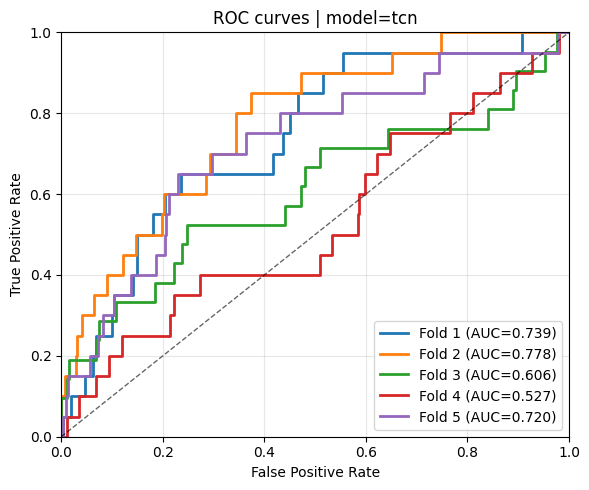

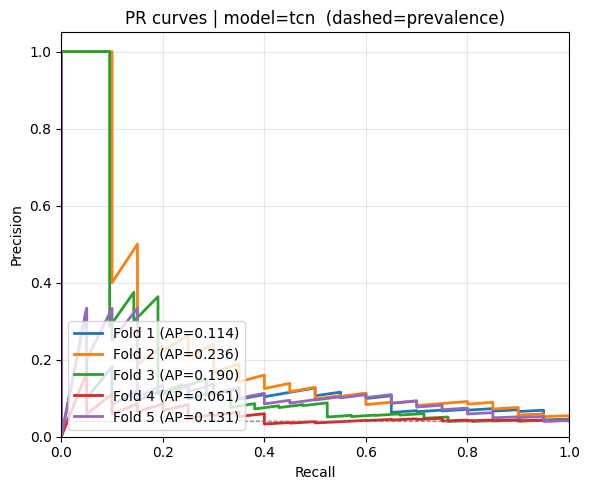

In [23]:
# 7C) Plot ROC curve & PR curve (mỗi plot gồm 5 đường = 5 folds)

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

results_dir = RESULTS_DIR if "RESULTS_DIR" in globals() else (ARTIFACTS_DIR / "results")
models_dir = MODELS_DIR if "MODELS_DIR" in globals() else (ARTIFACTS_DIR / "models")
results_dir = Path(results_dir)
models_dir = Path(models_dir)

# Auto-pick best by PR mean if summary exists; otherwise default
MODEL_FOR_CURVES = None
summary_path = results_dir / "all_models_5fold_summary.csv"
if summary_path.exists():
    s = pd.read_csv(summary_path, index_col=0)
    if "pr_auc_mean" in s.columns:
        MODEL_FOR_CURVES = str(s["pr_auc_mean"].idxmax())
if MODEL_FOR_CURVES is None:
    MODEL_FOR_CURVES = "bilstm"
MODEL_FOR_CURVES = str(MODEL_FOR_CURVES).lower().strip()
print("MODEL_FOR_CURVES:", MODEL_FOR_CURVES)

required_syms = [
    "folds_disk",
    "labels_by_caseid",
    "load_case_npz_raw",
    "apply_scalers_to_x",
    "load_fold_scalers",
    "AKILSTM_Logits",
    "BiLSTM_Logits",
    "AKIGRU_Logits",
    "TCNClassifier",
    "INPUT_DIM",
]
missing = [s for s in required_syms if s not in globals()]
if missing:
    raise RuntimeError(
        "Thiếu symbols từ Step 7. Hãy chạy lại Cell 17 và 18 trước. Missing: " + ", ".join(missing)
    )


def _build_model_from_key(model_key: str):
    mk = str(model_key).lower().strip()
    if mk == "lstm":
        return AKILSTM_Logits(INPUT_DIM)
    if mk == "bilstm":
        return BiLSTM_Logits(INPUT_DIM)
    if mk == "gru":
        return AKIGRU_Logits(INPUT_DIM)
    if mk == "tcn":
        return TCNClassifier(INPUT_DIM)
    raise ValueError(f"Unknown model_key={model_key}. Use one of: lstm, bilstm, gru, tcn")


class _ValDataset(Dataset):
    def __init__(self, caseids, fold_idx: int):
        self.caseids = [int(c) for c in caseids]
        self.fold_idx = int(fold_idx)
        self.scalers = load_fold_scalers(self.fold_idx)

    def __len__(self):
        return len(self.caseids)

    def __getitem__(self, idx: int):
        caseid = int(self.caseids[idx])
        x, valid_len = load_case_npz_raw(caseid)
        x = apply_scalers_to_x(x, valid_len=valid_len, scalers=self.scalers)
        x = x[:, :valid_len].T.astype(np.float32)
        y = float(labels_by_caseid[caseid])
        return torch.from_numpy(x), torch.tensor([y], dtype=torch.float32), int(valid_len)


def _pad(batch):
    xs, ys, lens = zip(*batch)
    lengths = torch.tensor(lens, dtype=torch.long)
    max_len = int(lengths.max().item()) if len(lengths) else 0
    feat_dim = int(xs[0].shape[1])
    X = torch.zeros((len(xs), max_len, feat_dim), dtype=torch.float32)
    y = torch.stack([yy.reshape(1) for yy in ys], dim=0).float()
    for i, x in enumerate(xs):
        L = int(x.shape[0])
        X[i, :L] = x
    return X, y, lengths


def _predict_fold(model_key: str, fold_idx: int, val_ids):
    dev = torch.device(DEVICE if "DEVICE" in globals() else ("cuda" if torch.cuda.is_available() else "cpu"))
    ckpt_path = models_dir / str(model_key).lower().strip() / f"fold{int(fold_idx)}.pt"
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Không tìm thấy checkpoint: {ckpt_path}. Hãy chạy Cell 18 trước.")

    model = _build_model_from_key(model_key).to(dev)
    ckpt = torch.load(ckpt_path, map_location=dev)
    model.load_state_dict(ckpt["model_state"], strict=True)
    model.eval()

    ds = _ValDataset(val_ids, fold_idx)
    loader = DataLoader(ds, batch_size=int(BATCH_SIZE) if "BATCH_SIZE" in globals() else 32, shuffle=False, num_workers=0, collate_fn=_pad)

    y_true_all, y_prob_all = [], []
    with torch.no_grad():
        for Xb, yb, lengths in loader:
            logits = model(Xb.to(dev), lengths.to(dev))
            prob = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
            y_true = yb.detach().cpu().numpy().reshape(-1)
            y_true_all.extend(y_true.tolist())
            y_prob_all.extend(prob.tolist())

    return np.asarray(y_true_all, dtype=int), np.asarray(y_prob_all, dtype=float)


roc_lines = []
pr_lines = []
for f in folds_disk:
    fold_idx = int(f["fold"])
    val_ids = [int(x) for x in f["val_caseids"]]
    y_true, y_prob = _predict_fold(MODEL_FOR_CURVES, fold_idx, val_ids)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = float(auc(fpr, tpr))

    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = float(average_precision_score(y_true, y_prob))

    roc_lines.append((fold_idx, fpr, tpr, roc_auc))
    pr_lines.append((fold_idx, rec, prec, ap, float(y_true.mean())))

# ROC
plt.figure(figsize=(6, 5))
for fold_idx, fpr, tpr, roc_auc in sorted(roc_lines, key=lambda x: x[0]):
    plt.plot(fpr, tpr, linewidth=2, label=f"Fold {fold_idx} (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1, alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC curves | model={MODEL_FOR_CURVES}")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# PR
plt.figure(figsize=(6, 5))
for fold_idx, rec, prec, ap, prev in sorted(pr_lines, key=lambda x: x[0]):
    plt.plot(rec, prec, linewidth=2, label=f"Fold {fold_idx} (AP={ap:.3f})")
    # random baseline for that fold
    plt.hlines(prev, 0, 1, colors="gray", linestyles="--", linewidth=0.8, alpha=0.35)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"PR curves | model={MODEL_FOR_CURVES}  (dashed=prevalence)")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

MODEL_FOR_CM: tcn
THRESH: 0.5


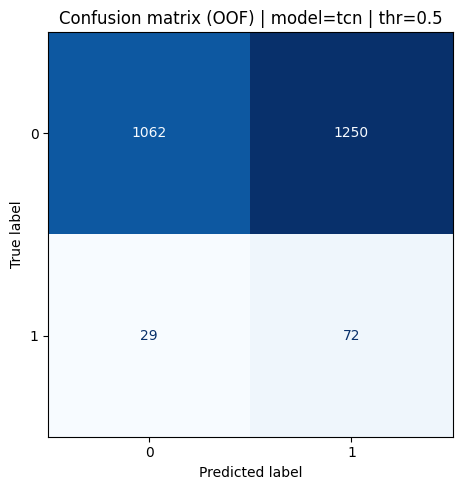

OOF metrics @ threshold: {'acc': 0.4699544135930377, 'precision': 0.05446293494704992, 'recall': 0.7128712871287128, 'f1': 0.10119465917076599}
Counts: {'n': 2413, 'pos': 101, 'neg': 2312}


In [24]:
# 7D) Plot confusion matrix (OOF prediction từ 5 folds)

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

results_dir = RESULTS_DIR if "RESULTS_DIR" in globals() else (ARTIFACTS_DIR / "results")
models_dir = MODELS_DIR if "MODELS_DIR" in globals() else (ARTIFACTS_DIR / "models")
results_dir = Path(results_dir)
models_dir = Path(models_dir)

# Auto-pick best by PR mean if summary exists; otherwise default
MODEL_FOR_CM = None
summary_path = results_dir / "all_models_5fold_summary.csv"
if summary_path.exists():
    s = pd.read_csv(summary_path, index_col=0)
    if "pr_auc_mean" in s.columns:
        MODEL_FOR_CM = str(s["pr_auc_mean"].idxmax())
if MODEL_FOR_CM is None:
    MODEL_FOR_CM = "bilstm"
MODEL_FOR_CM = str(MODEL_FOR_CM).lower().strip()

THRESH = 0.5
print("MODEL_FOR_CM:", MODEL_FOR_CM)
print("THRESH:", THRESH)

required_syms = [
    "folds_disk",
    "labels_by_caseid",
    "load_case_npz_raw",
    "apply_scalers_to_x",
    "load_fold_scalers",
    "AKILSTM_Logits",
    "BiLSTM_Logits",
    "AKIGRU_Logits",
    "TCNClassifier",
    "INPUT_DIM",
]
missing = [s for s in required_syms if s not in globals()]
if missing:
    raise RuntimeError("Thiếu symbols từ Step 7. Hãy chạy lại Cell 17 và 18 trước.")


def _build_model_from_key(model_key: str):
    mk = str(model_key).lower().strip()
    if mk == "lstm":
        return AKILSTM_Logits(INPUT_DIM)
    if mk == "bilstm":
        return BiLSTM_Logits(INPUT_DIM)
    if mk == "gru":
        return AKIGRU_Logits(INPUT_DIM)
    if mk == "tcn":
        return TCNClassifier(INPUT_DIM)
    raise ValueError(f"Unknown model_key={model_key}. Use one of: lstm, bilstm, gru, tcn")


class _ValDatasetWithId(Dataset):
    def __init__(self, caseids, fold_idx: int):
        self.caseids = [int(c) for c in caseids]
        self.fold_idx = int(fold_idx)
        self.scalers = load_fold_scalers(self.fold_idx)

    def __len__(self):
        return len(self.caseids)

    def __getitem__(self, idx: int):
        caseid = int(self.caseids[idx])
        x, valid_len = load_case_npz_raw(caseid)
        x = apply_scalers_to_x(x, valid_len=valid_len, scalers=self.scalers)
        x = x[:, :valid_len].T.astype(np.float32)
        y = float(labels_by_caseid[caseid])
        return caseid, torch.from_numpy(x), torch.tensor([y], dtype=torch.float32), int(valid_len)


def _pad_with_id(batch):
    caseids, xs, ys, lens = zip(*batch)
    lengths = torch.tensor(lens, dtype=torch.long)
    max_len = int(lengths.max().item()) if len(lengths) else 0
    feat_dim = int(xs[0].shape[1])
    X = torch.zeros((len(xs), max_len, feat_dim), dtype=torch.float32)
    y = torch.stack([yy.reshape(1) for yy in ys], dim=0).float()
    for i, x in enumerate(xs):
        L = int(x.shape[0])
        X[i, :L] = x
    return list(caseids), X, y, lengths


def predict_oof(model_key: str):
    dev = torch.device(DEVICE if "DEVICE" in globals() else ("cuda" if torch.cuda.is_available() else "cpu"))
    y_true_all, y_prob_all, cid_all = [], [], []

    for f in folds_disk:
        fold_idx = int(f["fold"])
        val_ids = [int(x) for x in f["val_caseids"]]

        ckpt_path = models_dir / str(model_key).lower().strip() / f"fold{fold_idx}.pt"
        if not ckpt_path.exists():
            raise FileNotFoundError(f"Không tìm thấy checkpoint: {ckpt_path}. Hãy chạy Cell 18 trước.")

        model = _build_model_from_key(model_key).to(dev)
        ckpt = torch.load(ckpt_path, map_location=dev)
        model.load_state_dict(ckpt["model_state"], strict=True)
        model.eval()

        ds = _ValDatasetWithId(val_ids, fold_idx)
        loader = DataLoader(ds, batch_size=int(BATCH_SIZE) if "BATCH_SIZE" in globals() else 32, shuffle=False, num_workers=0, collate_fn=_pad_with_id)

        with torch.no_grad():
            for cids, Xb, yb, lengths in loader:
                logits = model(Xb.to(dev), lengths.to(dev))
                prob = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
                y_true = yb.detach().cpu().numpy().reshape(-1)

                cid_all.extend([int(c) for c in cids])
                y_true_all.extend(y_true.tolist())
                y_prob_all.extend(prob.tolist())

    return np.asarray(cid_all, dtype=int), np.asarray(y_true_all, dtype=int), np.asarray(y_prob_all, dtype=float)


cid, y_true, y_prob = predict_oof(MODEL_FOR_CM)
y_pred = (y_prob >= float(THRESH)).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
ax.set_title(f"Confusion matrix (OOF) | model={MODEL_FOR_CM} | thr={THRESH}")
plt.tight_layout()
plt.show()

metrics = {
    "acc": float(accuracy_score(y_true, y_pred)),
    "precision": float(precision_score(y_true, y_pred, zero_division=0)),
    "recall": float(recall_score(y_true, y_pred, zero_division=0)),
    "f1": float(f1_score(y_true, y_pred, zero_division=0)),
}
print("OOF metrics @ threshold:", metrics)
print("Counts:", {"n": int(len(y_true)), "pos": int(y_true.sum()), "neg": int((1 - y_true).sum())})